### Donor's Choose Application Screening



In [165]:
'''
To save time required in data pre processing, 
we have added textProcessingDone and nonTextProcessingDone flags 
to indicate that the pre-processing is already performed 
so data can be loaded from pre-processed files.  

Please set the flags to false to rewrite the files. 
'''

textProcessingDone = True
nonTextProcessingDone = True

In [166]:
import pandas as pd
import functools as ft
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import pandas as pd
import numpy as np
from math import log,sqrt
import nltk
from nltk import WordNetLemmatizer
import re
#import inflect
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pk
import time
from scipy import sparse
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# from textblob import TextBlob
#import enchant
stopword_list=stopwords.words('english')

### Data Preprocessing 

In [167]:
'''
Project categories and sub categories were given in a group. 
This function splits it to generate unique categories accross all applications. 

'''
def get_category_encoding(column_name,dataframe):
    all_split_categories=dataframe[[column_name]].applymap(lambda x:map(lambda y : y.strip(),x.split(',')))
    return all_split_categories[column_name].str.join('|').str.get_dummies()

In [177]:
'''
Pre-processing of non textual data
1. Generated columns Year, Month, Day, Weekday and dateTimeMilliSeconds(continuous feature) from project_submitted_datetime
2. Dummy Coded teacher prefix 
3. Generated column gender from teacher prefix
4. Combined essay1, essay2, essay3 and essay4 into one essay. Removed special characters from essay
5. Encoding of Project grade categories 
6. Generated Word count as a feature from essay
7. Generated sent_polarity and sent_subjectivity from essay
8. Dropped essay1, essay2, essay3, essay4, project_categories and project_subCategories
9. Saved sentiment in other file for further processing

'''
def nonTextPreprocessing(filename):
    train_data=pd.read_csv(filename+".csv")
    train_df=pd.DataFrame(train_data)
    train_df['project_submitted_datetime'] = pd.to_datetime(train_df['project_submitted_datetime'])
    train_df['year'] = train_df['project_submitted_datetime'].dt.year
    train_df['month']= train_df['project_submitted_datetime'].dt.month
    train_df['day']= train_df['project_submitted_datetime'].dt.day
    weekday_map_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    train_df['weekday'] = train_df['project_submitted_datetime'].dt.weekday.map(weekday_map_dict)
    epoch = datetime.datetime.utcfromtimestamp(0)
    train_df['dateTimeMilliSeconds'] = train_df.project_submitted_datetime.apply(lambda x : (x - epoch).total_seconds())
    
    train_df.drop(['project_submitted_datetime'], axis=1,inplace=True)
    
    train_df['teacher_prefix'].value_counts()
    genderMap={'Mr.':1,'Mrs.':0,'Ms.':0,'Teacher':-1,'Dr.':-1} #Male = 1 and Female =0
    train_df['gender']=train_df['teacher_prefix'].map(genderMap)
    train_df['gender'][train_df['gender']==-1] =  np.random.choice([1,0],len(train_df['gender'][train_df['gender']==-1]),p = [0.1,0.9])
    
    train_df['train_df'].value_counts()
    gradeMap={'Grades PreK-2':1,'Grades 3-5':2,'Grades 6-8':3,'Grades 9-12':4}
    train_df['project_grade_category']=train_df['project_grade_category'].map(gradeMap)
    
    ###procesing for essays
    train_df['essay'] = train_df.project_essay_1.map(str) + train_df.project_essay_2.map(str) + train_df.project_essay_3.map(str) if train_df.project_essay_3 is not None else ''+ train_df.project_essay_4.map(str) if train_df.project_essay_4 is not None else ''
    
    def get_polarity(text):
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
        return round(pol,2)

    def get_subjectivity(text):
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
        return round(subj,2)
    
    train_df['sent_polarity'] = train_df['essay'].apply(get_polarity)
    train_df['sent_subjectivity'] = train_df['essay'].apply(get_subjectivity)
    
    #train_df['essay_tokens'] = train_df[['essay']].applymap(lambda x : word_tokenize(x))
    #train_df['spell_checker']=train_df['essay_tokens'].apply(spellCheck)
    ##dropping essay related columns
    train_df.drop(['project_essay_1'], axis=1,inplace=True)
    train_df.drop(['project_essay_2'], axis=1,inplace=True)
    train_df.drop(['project_essay_3'], axis=1,inplace=True)
    train_df.drop(['project_essay_4'], axis=1,inplace=True)
    
    #train_df.drop(['essay_tokens'],axis=1,inplace=True)
    
    ###essay prelim procesing 
    train_df['essay'] = train_df.essay.apply(lambda x: x.replace("\\n", "").replace("\\r", ""))
    train_df['essay'] = train_df.essay.apply(lambda x: re.sub (r'([^a-zA-Z\d\"\'\- ]+)', '', x))
    train_df['project_title'] = train_df.essay.apply(lambda x: re.sub (r'([^a-zA-Z ]+)', '', x))
    train_df['Word_count'] = train_df.essay.apply(lambda x: len(x.split()))
    
    project_subcategories_coded=get_category_encoding('project_subject_subcategories',train_df)
    project_categories_coded=get_category_encoding('project_subject_categories',train_df)
    
    train_df.drop(['project_subject_categories'],axis=1,inplace=True)
    train_df.drop(['project_subject_subcategories'],axis=1,inplace=True)
    ##adding sub and categories
    train_df=pd.concat([train_df,project_categories_coded,project_subcategories_coded],axis = 1)
                                                               
    
    train_df.to_csv(filename+"_withSentiments.gz", compression = 'gzip')
    
    
    return train_df

In [178]:
def pipelineText(wordsAsList):
    # p = inflect.engine() 
    new_words = []
    lemmatizer = WordNetLemmatizer()
    
    for word in wordsAsList:
        
        new_word = word.lower()
       
        new_word = re.sub(r'[^\d\w\s]', '', new_word)
        
        # if re.match(r'.\d.', new_word):
        #     digit_part=re.search('\d(?:th|rd|nd|st)?',new_word).group()
        #     digit_part = p.number_to_words(digit_part)
        #     new_words.append(digit_part)
        #     new_word=re.subn('\d(?:th|rd|nd|st)?','',new_word)[0]
            

        if new_word not in stopword_list:
            
            new_word = lemmatizer.lemmatize(new_word, pos='v')
            new_word = lemmatizer.lemmatize(new_word, pos='n')
            new_word = lemmatizer.lemmatize(new_word, pos='r')
            new_word = lemmatizer.lemmatize(new_word, pos='a')
            try:
                new_word=wordnet.synset(new_word+'.r'+'.1').lemmas()[0].pertainyms()[0].name()
            except:
                pass
            
            if new_word != '' :
                new_words.append(new_word)
    return new_words

In [179]:
if not nonTextProcessingDone:
    train_df=nonTextPreprocessing('train')
    test_df=nonTextPreprocessing('test')
    
train_df=pd.read_csv("train_withSentiments.gz")
train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]
test_df=pd.read_csv("test_withSentiments.gz")
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]

In [160]:
def fill_Mode_Median(df):
    continuousVariables = df.select_dtypes('int64').columns.tolist() + df.select_dtypes('float64').columns.tolist()
    categoricalVariables = df.select_dtypes('category').columns.tolist() + df.select_dtypes('object').columns.tolist()
    df[continuousVariables] = df[continuousVariables].fillna(df[continuousVariables].median())
    df[categoricalVariables] = df[categoricalVariables].fillna(df[categoricalVariables].mode().iloc[0])#mode could have multiple values

In [180]:
train_resources_data=pd.read_csv("resources.csv")
train_resources_df=pd.DataFrame(train_resources_data)
train_resources_df=train_resources_df.dropna()
# 292 NAs in description dropped

train_resources_df['Total Price']=train_resources_df['quantity']*train_resources_df['price']
train_resources_df=train_resources_df.groupby(['id']).agg({'description':lambda x:' '.join(x),'Total Price':'sum'})
train_resources_df['projectid'] = train_resources_df.index
combined_df = train_df.set_index('id').join(train_resources_df.set_index('projectid'), how='left') 
fill_Mode_Median(combined_df)


combined_test_df = test_df.set_index('id').join(train_resources_df.set_index('projectid'), how='left') 
fill_Mode_Median(combined_test_df)



In [162]:

train_df = combined_df
test_df = combined_test_df

### Exploratory data analysis

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4F67836A0>],
      dtype=object)

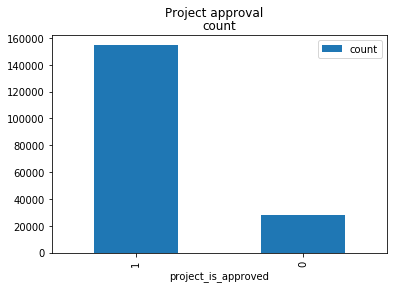

In [195]:
# Project approval distribution

plotDf = combined_df['project_is_approved'].value_counts()
plot_df = pd.DataFrame(index = None)
plot_df['project_is_approved'] = list(plotDf.index)
plot_df['count'] = plotDf.values
plot_df = plot_df.set_index('project_is_approved')
plot_df.plot(kind='bar', subplots=True, title ='Project approval')

C:\Users\harsh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


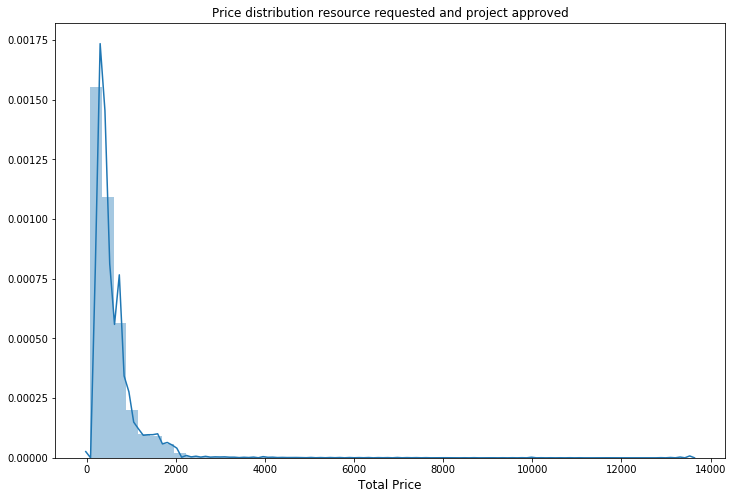

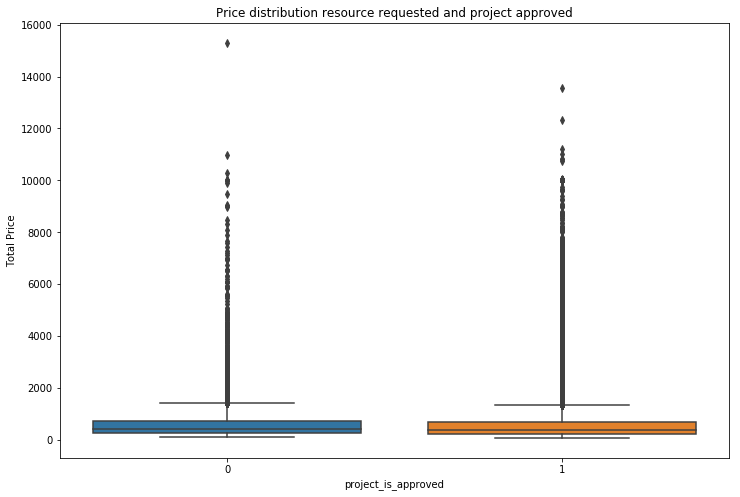

C:\Users\harsh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


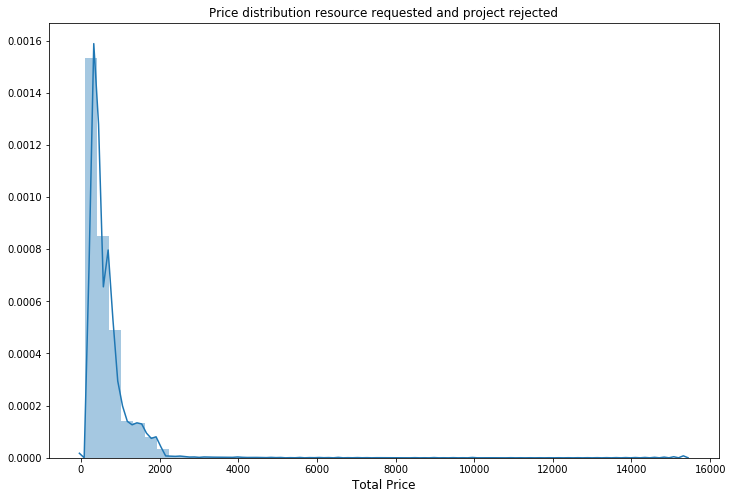

In [193]:
# EDA 
# Plot showing total price of resorces requested

plot_df = combined_df.loc[combined_df['project_is_approved'] == 1]
plt.figure(figsize = (12, 8))
sns.distplot(plot_df['Total Price'])
plt.xlabel('Total Price', fontsize=12)
plt.title("Price distribution resource requested and project approved")
plt.show() 

plot_df = combined_df.loc[combined_df['project_is_approved'] == 1]
plt.figure(figsize = (12, 8))
sns.boxplot(y = combined_df['Total Price'],x = combined_df['project_is_approved'])
# plt.xlabel('0, 1')
plt.title("Price distribution resource requested and project approved")
plt.show() 

plot_df = combined_df.loc[combined_df['project_is_approved'] == 0]
plt.figure(figsize = (12, 8))
sns.distplot(plot_df['Total Price'])
plt.xlabel('Total Price', fontsize=12)
plt.title("Price distribution resource requested and project rejected")
plt.show() 


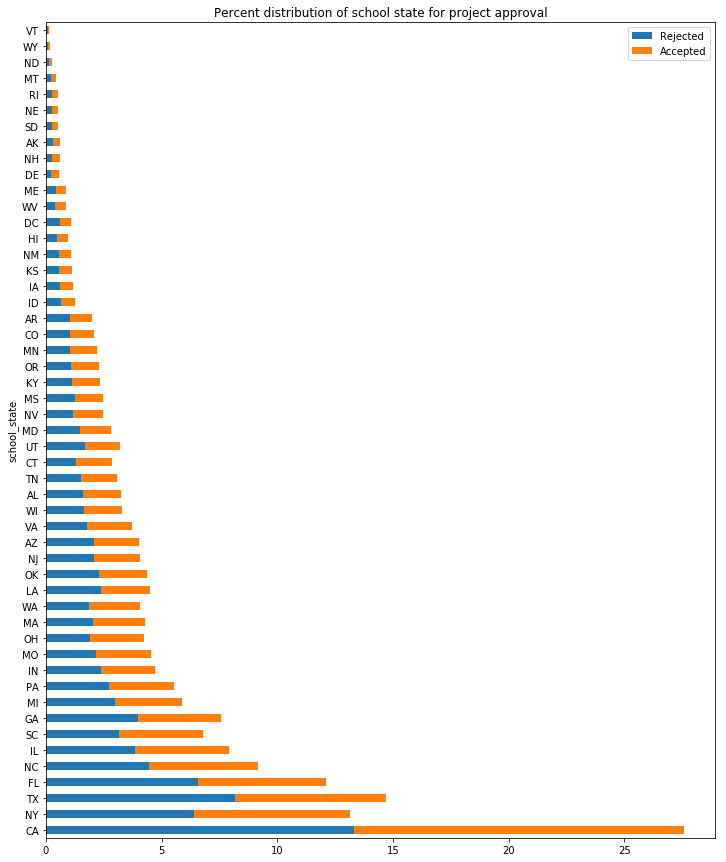

In [171]:
# School state wise distribution

plot_df = train_df.groupby(['school_state', 'project_is_approved'])['school_state'].count().unstack('project_is_approved').sort_values(1, ascending = False)
plot_df[0] = (plot_df[0]/(plot_df[0].sum()) * 100)
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='barh', stacked = True, figsize = (12,15), title = 'Percent distribution of school state for project approval')

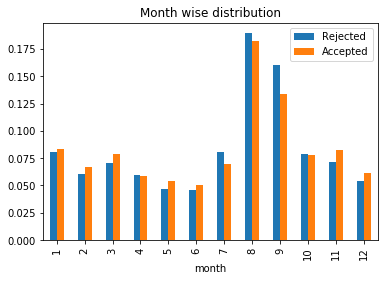

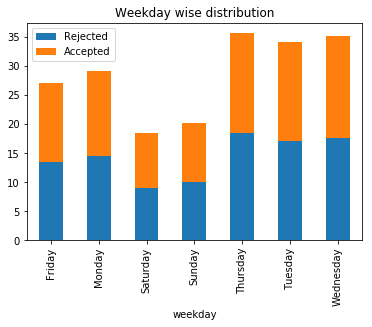

In [172]:
# EDA on project_submission date time

plot_df = train_df.groupby(['month', 'project_is_approved'])['month'].count().unstack('project_is_approved')
plot_df[0] = plot_df[0]/(plot_df[0].sum())
plot_df[1] = plot_df[1]/plot_df[1].sum()
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='bar', title = 'Month wise distribution')

plot_df = train_df.groupby(['weekday', 'project_is_approved'])['weekday'].count().unstack('project_is_approved')
plot_df[0] = (plot_df[0]/(plot_df[0].sum())) * 100
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='bar', stacked = True, title = 'Weekday wise distribution')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5323E97F0>,
      dtype=object)

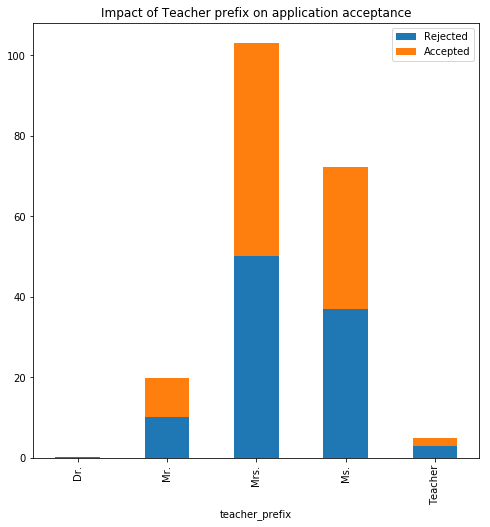

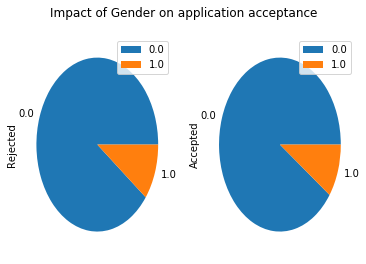

In [184]:
## EDA to see effect of teacher prefix and gender on project approval

plot_df = train_df.groupby(['teacher_prefix', 'project_is_approved'])['teacher_prefix'].count().unstack('project_is_approved')
plot_df[0] = (plot_df[0]/(plot_df[0].sum()) * 100)
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='bar', stacked = True, figsize = (8,8), title = 'Impact of Teacher prefix on application acceptance') 

plot_df = train_df.groupby(['gender', 'project_is_approved'])['gender'].count().unstack('project_is_approved')
plot_df[0] = (plot_df[0]/(plot_df[0].sum()) * 100)
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='pie', subplots=True, title = 'Impact of Gender on application acceptance') 


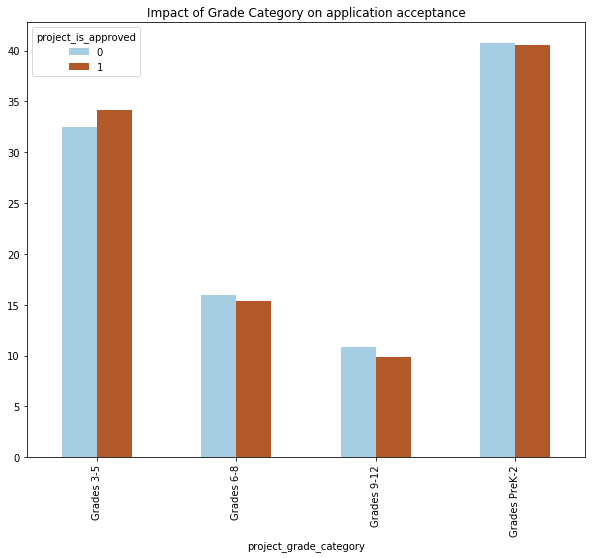

In [186]:
# EDA For project grade and its effect on project approval
eda_data=pd.read_csv("train.csv")
eda_df=pd.DataFrame(eda_data)
plot_df = eda_df.groupby(['project_grade_category', 'project_is_approved'])['project_grade_category'].count().unstack('project_is_approved')
plot_df[0] = (plot_df[0]/(plot_df[0].sum()) * 100)
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.plot(kind='bar', colormap = 'Paired', figsize = (10,8),title="Impact of Grade Category on application acceptance")


Project Sub categories
Literacy                                        15775
Literacy, Mathematics                           13863
Literature & Writing, Mathematics                9976
Literacy, Literature & Writing                   9282
Mathematics                                      9041
Literature & Writing                             7474
Special Needs                                    7065
Health & Wellness                                5924
Applied Sciences, Mathematics                    5651
Literacy, Special Needs                          4091
Applied Sciences                                 4037
Gym & Fitness, Health & Wellness                 3864
Visual Arts                                      3671
ESL, Literacy                                    3624
Music                                            2427
Literature & Writing, Special Needs              2244
Warmth, Care & Hunger                            2191
Health & Wellness, Special Needs                 2045
Gym &

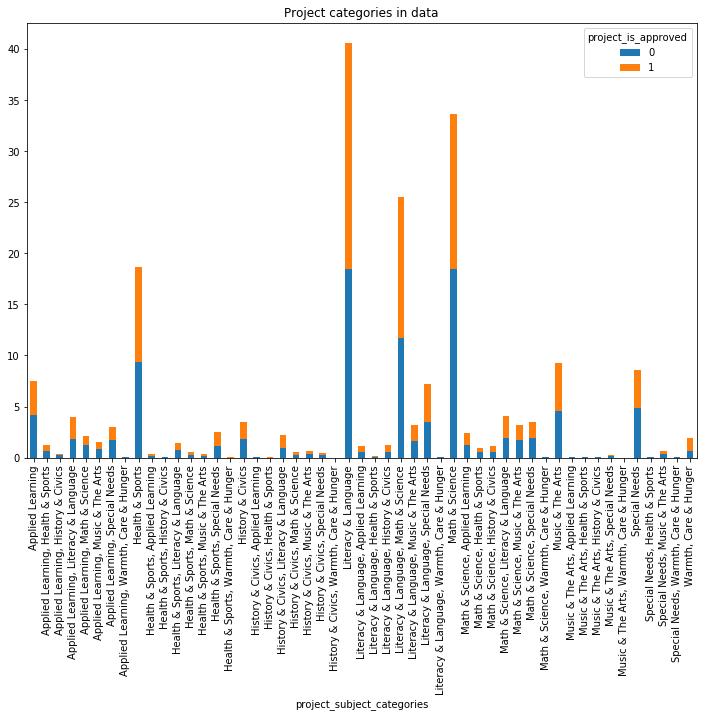

In [153]:
# Before preprocessing 
eda_data=pd.read_csv("train.csv")
eda_df=pd.DataFrame(eda_data)
plot_df = eda_df.groupby(['project_subject_categories', 'project_is_approved'])['project_subject_categories'].count().unstack('project_is_approved')
plot_df[0] = (plot_df[0]/(plot_df[0].sum()) * 100)
plot_df[1] = (plot_df[1]/plot_df[1].sum()) * 100
plot_df.plot(kind='bar', stacked = True, figsize = (12,8), title = 'Project categories in data') 

print('Project Sub categories')
print(eda_df['project_subject_subcategories'].value_counts())

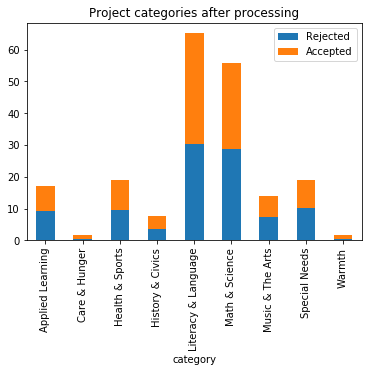

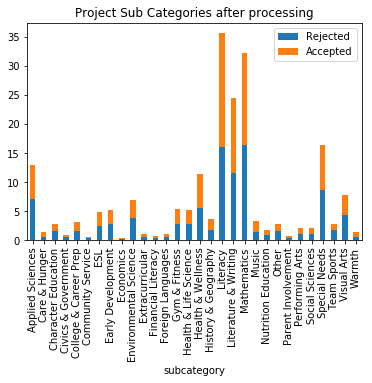

In [191]:
# After processing Project categories 
project_categories = ['Applied Learning', 'Care & Hunger', 'Health & Sports', \
       'History & Civics', 'Literacy & Language', 'Math & Science', \
       'Music & The Arts', 'Special Needs', 'Warmth']
li = []
for x in project_categories:
    arr= train_df.groupby([x, 'project_is_approved'])[x].count().unstack('project_is_approved').values[1]
    li.append({'category':  x , '0': arr[0], '1': arr[1]})
plot_df = pd.DataFrame(li)
plot_df['0'] = (plot_df['0']/(plot_df['0'].sum()) * 100)
plot_df['1'] = (plot_df['1']/plot_df['1'].sum()) * 100
plot_df = plot_df.set_index('category')
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='bar', stacked = True, title='Project categories after processing')

# After processing Project Sub categories 
project_sub_categories = ['Applied Sciences', 'Care & Hunger', 'Character Education', \
       'Civics & Government', 'College & Career Prep', 'Community Service', \
       'ESL', 'Early Development', 'Economics', 'Environmental Science', \
       'Extracurricular', 'Financial Literacy', 'Foreign Languages', \
       'Gym & Fitness', 'Health & Life Science', 'Health & Wellness', \
       'History & Geography', 'Literacy', 'Literature & Writing', \
       'Mathematics', 'Music', 'Nutrition Education', 'Other', \
       'Parent Involvement', 'Performing Arts', 'Social Sciences', \
       'Special Needs', 'Team Sports', 'Visual Arts', 'Warmth']
li = []
for x in project_sub_categories:
    arr= train_df.groupby([x, 'project_is_approved'])[x].count().unstack('project_is_approved').values[1]
    li.append({'subcategory':  x , '0': arr[0], '1': arr[1]})
plot_df = pd.DataFrame(li)
plot_df['0'] = (plot_df['0']/(plot_df['0'].sum()) * 100)
plot_df['1'] = (plot_df['1']/plot_df['1'].sum()) * 100
plot_df = plot_df.set_index('subcategory')
plot_df.columns = ['Rejected','Accepted']
plot_df.plot(kind='bar', stacked = True, title='Project Sub Categories after processing')

Text(0.5,1,'Frequency of word count bins vs project approval')

<Figure size 3600x1080 with 0 Axes>

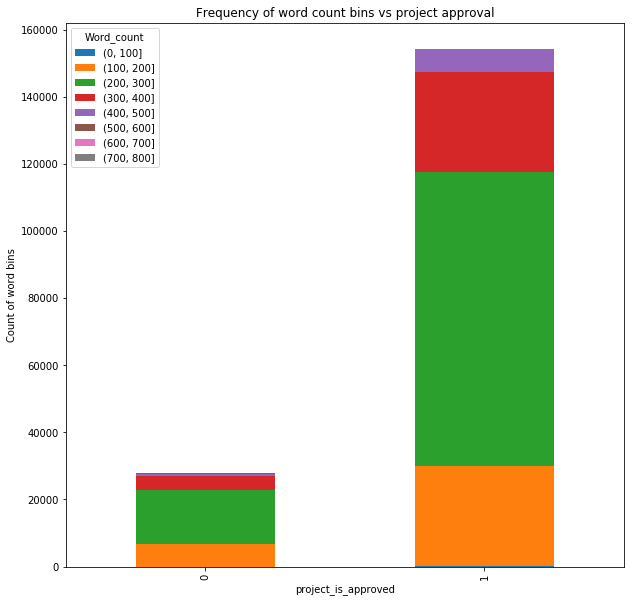

In [188]:
# Effect of Word count on project approval

bins = pd.IntervalIndex.from_tuples([(100*i,100*(i+1)) for i in range(8)])
tempDfForWordCount = pd.concat([pd.cut(train_df['Word_count'],bins),train_df['project_is_approved']],axis = 1)

tempDfForWordCount = tempDfForWordCount.groupby(['Word_count','project_is_approved'])['project_is_approved'].count().unstack('Word_count')
plt.figure(figsize=(50,15))
pltForWordCount = tempDfForWordCount.plot(kind = 'bar' ,stacked = True,figsize = (10,10))
plt.ylabel('Count of word bins')
plt.title("Frequency of word count bins vs project approval")

### Text Data Processing

In [119]:
'''
This function is used to process textual data such as essay, title and project summary if textProcessingDone is false
We have called pipeline_text function to clean and lemmatize words from essay, title and summary. 
To save time, we have saved these in files which can be imported for later executions. 


'''
if not textProcessingDone:
    print("Starting Essay vectorisation")
    essay_list=train_df[['essay']]
    essay_list['tokenised_essay'] = essay_list.applymap(lambda x :word_tokenize(x))
    print("Tokenised Essay")
    essay_list[['tokenised_essay']] = essay_list[['tokenised_essay']].applymap(lambda x: pipelineText(x))
    print("Pipeline finihed")
    
    essay_list[['tokenised_essay']]=essay_list[['tokenised_essay']].applymap(lambda x: ' '.join(x))
    
    essay_list.to_csv("essay_list_without_stemmer.gz", compression = 'gzip')
    
    
    
    ###project title vectorisation
    print("Title vectorisation started")
    project_title_column=train_df[['project_title']]
    project_title_column['tokenised_title'] = project_title_column.applymap(lambda x :word_tokenize(x))
    project_title_column[['tokenised_title']] = project_title_column[['tokenised_title']].applymap(lambda x: pipelineText(x))
    project_title_column[['tokenised_title']]=project_title_column[['tokenised_title']].applymap(lambda x: ' '.join(x))
    
    project_title_column.to_csv("project_title_without_stemmer.gz", compression = 'gzip')
    
    ###project resource summary vecorisations
    
    print("Resource summay vectoristion started")
    project_summary_column=train_df[['project_resource_summary']]
    project_summary_column['tokenised_summary'] = project_summary_column.applymap(lambda x :word_tokenize(x))
    project_summary_column[['tokenised_summary']] = project_summary_column[['tokenised_summary']].applymap(lambda x: pipelineText(x))
    project_summary_column[['tokenised_summary']]=project_summary_column[['tokenised_summary']].applymap(lambda x: ' '.join(x))
    
    project_summary_column.to_csv("project_summary_without_stemmer.gz", compression = 'gzip')
    
    
    """
    For Test files
    """
    print(" test Starting Essay vectorisation")
    essay_list=test_df[['essay']]
    essay_list['tokenised_essay'] = essay_list.applymap(lambda x :word_tokenize(x))
    print("Tokenised Essay")
    essay_list[['tokenised_essay']] = essay_list[['tokenised_essay']].applymap(lambda x: pipelineText(x))
    print("Pipeline finihed")
    
    essay_list[['tokenised_essay']]=essay_list[['tokenised_essay']].applymap(lambda x: ' '.join(x))
    
    essay_list.to_csv("test_essay_list_without_stemmer.gz", compression = 'gzip')
    
    
    
    ###project title vectorisation
    print("test Title vectorisation started")
    project_title_column=test_df[['project_title']]
    project_title_column['tokenised_title'] = project_title_column.applymap(lambda x :word_tokenize(x))
    project_title_column[['tokenised_title']] = project_title_column[['tokenised_title']].applymap(lambda x: pipelineText(x))
    project_title_column[['tokenised_title']]=project_title_column[['tokenised_title']].applymap(lambda x: ' '.join(x))
    
    project_title_column.to_csv("test_project_title_without_stemmer.gz", compression = 'gzip')
    
    ###project resource summary vecorisations
    
    print("test Resource summay vectoristion started")
    project_summary_column=test_df[['project_resource_summary']]
    project_summary_column['tokenised_summary'] = project_summary_column.applymap(lambda x :word_tokenize(x))
    project_summary_column[['tokenised_summary']] = project_summary_column[['tokenised_summary']].applymap(lambda x: pipelineText(x))
    project_summary_column[['tokenised_summary']]=project_summary_column[['tokenised_summary']].applymap(lambda x: ' '.join(x))
    
    project_summary_column.to_csv("test_project_summary_without_stemmer.gz", compression = 'gzip')


In [120]:
'''
We have used TfidfVectorizer for all text features like essay, project title and summary. 
Input to this function is generated pre-processed train and test files for essay, title and summary. 
Speatate vectorizer is generated for essay, title and summary. 
We have used same vectorizer object in train and test to maintain the vocabulary common for both.  
The dummy coded data is stored in a spased matrix to save memory
'''
def TextVectorizer(essay_file,title_file,summary_file,test_essay_file,test_title_file,test_summary_file):
    essay_list = pd.read_csv(essay_file)
    essay_list  =essay_list.drop(essay_list.columns[0], axis =1)
    vectorizerForEssay = TfidfVectorizer()
    essay_list_dummy_coded = vectorizerForEssay.fit_transform(essay_list['tokenised_essay'])
    columnDictForEssay = {value :  'fromEssay_'+str(key) for key, value in vectorizerForEssay.vocabulary_.items()}
    lengthOfEssayColumnDict = len(columnDictForEssay)
    
    project_title_column = pd.read_csv(title_file)
    project_title_column  =project_title_column.drop(project_title_column.columns[0], axis =1)
    project_title_column.fillna("",inplace=True)
    vectorizerForTitle = TfidfVectorizer()
    project_title_dummy_coded = vectorizerForTitle.fit_transform(project_title_column['tokenised_title'])
    columnDictForTitle = {value+lengthOfEssayColumnDict :  'fromTitle_'+str(key) for key, value in vectorizerForTitle.vocabulary_.items()}
    lengthOfColumnTitle=len(columnDictForTitle)
    
    project_summary_column = pd.read_csv(summary_file)
    project_summary_column  =project_summary_column.drop(project_summary_column.columns[0], axis =1)
    vectorizerForSummary = TfidfVectorizer()
    project_summary_dummy_coded = vectorizerForSummary.fit_transform(project_summary_column['tokenised_summary'])
    columnDictForResources = {value+lengthOfEssayColumnDict+lengthOfColumnTitle :  'fromResSumm_'+str(key) for key, value in vectorizerForSummary.vocabulary_.items()}
    
    # Combine data of essay, title and project summary
    sparseAll=sparse.hstack([essay_list_dummy_coded,project_title_dummy_coded,project_summary_dummy_coded])
    
    ''' Processing for test files'''
    essay_list = pd.read_csv(test_essay_file)
    essay_list  =essay_list.drop(essay_list.columns[0], axis =1)
    
    # Used same vectorizer object as train to maintain vocabulary
    essay_list_dummy_coded = vectorizerForEssay.transform(essay_list['tokenised_essay'])
    
    project_title_column = pd.read_csv(test_title_file)
    project_title_column  =project_title_column.drop(project_title_column.columns[0], axis =1)
    project_title_column.fillna("",inplace=True)
    #vectorizerForTitle = TfidfVectorizer()
    project_title_dummy_coded = vectorizerForTitle.transform(project_title_column['tokenised_title'])
    
    project_summary_column = pd.read_csv(test_summary_file)
    project_summary_column  =project_summary_column.drop(project_summary_column.columns[0], axis =1)
    #vectorizerForSummary = TfidfVectorizer()
    project_summary_dummy_coded = vectorizerForSummary.transform(project_summary_column['tokenised_summary'])
    
    # Combine data of essay, title and project summary
    sparseAll_test=sparse.hstack([essay_list_dummy_coded,project_title_dummy_coded,project_summary_dummy_coded])
    
    
    
    AllWordMappingDict  = {}
    AllWordMappingDict.update(columnDictForEssay)
    AllWordMappingDict.update(columnDictForTitle)
    AllWordMappingDict.update(columnDictForResources)
    
    return AllWordMappingDict,sparseAll,sparseAll_test


In [121]:
AllWordMappingDict,sparseAll,sparseAll_test=TextVectorizer('essay_list_without_stemmer.gz','project_title_without_stemmer.gz',
                'project_summary_without_stemmer.gz','test_essay_list_without_stemmer.gz',
                'test_project_title_without_stemmer.gz','test_project_summary_without_stemmer.gz')  

### Applying Models

In [42]:
from sklearn.model_selection import train_test_split

X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(sparseAll,
                                                              train_df['project_is_approved'], 
                                                              test_size=0.20, random_state=2018)

In [43]:
'''
Light GBM Model 
'''
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 7,
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
    }  

import lightgbm as lgb
evals_result = {}  # to record eval results for plotting
model_lgb_word = lgb.train(
        params,
        lgb.Dataset(X_train_l, y_train_l),
        num_boost_round=500,
        valid_sets=[lgb.Dataset(X_valid_l, y_valid_l)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)
    
    
# Get important features from model
featureImportanceDf = pd.DataFrame({'feature names' : model_lgb_word.feature_name(), 'feature importance' :  model_lgb_word.feature_importance()})

featureImportanceDf['Columns_Number'] =  featureImportanceDf['feature names'].str.replace('Column_','').astype('int32')

featureImportanceDf['WordList'] = featureImportanceDf['Columns_Number'].map(AllWordMappingDict) 

featureImportanceDf.sort_values(['feature importance'], ascending = False,inplace = True)

# Important word features
importantWordFeatures = featureImportanceDf.iloc[:10000,:].loc[:,'Columns_Number'].tolist()


Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.665359
[50]	valid_0's auc: 0.676293
[75]	valid_0's auc: 0.686275
[100]	valid_0's auc: 0.694527
[125]	valid_0's auc: 0.700646
[150]	valid_0's auc: 0.704956
[175]	valid_0's auc: 0.709264
[200]	valid_0's auc: 0.712415
[225]	valid_0's auc: 0.715561
[250]	valid_0's auc: 0.718287
[275]	valid_0's auc: 0.720756
[300]	valid_0's auc: 0.722549
[325]	valid_0's auc: 0.724537
[350]	valid_0's auc: 0.72622
[375]	valid_0's auc: 0.727559
[400]	valid_0's auc: 0.728924
[425]	valid_0's auc: 0.730236
[450]	valid_0's auc: 0.731387
[475]	valid_0's auc: 0.732959
[500]	valid_0's auc: 0.734281
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.734281


In [44]:
'''
Generate word cloud based on important feature.
'''
wordScoringDf = featureImportanceDf.iloc[:2000,:][featureImportanceDf.iloc[:2000,:]['feature importance']>0]

wordScoringForEssay = wordScoringDf[wordScoringDf['WordList'].str.contains("fromEssay")]
wordScoringForSummary = wordScoringDf[wordScoringDf['WordList'].str.contains("fromResSumm")]
wordScoringForTitle = wordScoringDf[wordScoringDf['WordList'].str.contains("fromTitle")]
wordScoringForEssay['ActualWords'] = wordScoringForEssay['WordList'].str.split("_",expand = True)[1]
wordScoringForSummary['ActualWords'] = wordScoringForSummary['WordList'].str.split("_",expand = True)[1]
wordScoringForTitle['ActualWords'] = wordScoringForTitle['WordList'].str.split("_",expand = True)[1]

essay_list = pd.read_csv("essay_list_without_stemmer.gz")
# essay_list  =essay_list.drop(essay_list.columns[0], axis =1)
project_title_column = pd.read_csv("project_title_without_stemmer.gz")
# project_title_column  =project_title_column.drop(project_title_column.columns[0], axis =1)
project_summary_column = pd.read_csv("project_summary_without_stemmer.gz")
# project_summary_column  =project_summary_column.drop(project_summary_column.columns[0], axis =1)

allTextRelavantColumns = pd.concat([essay_list['tokenised_essay'],
                                    project_title_column['tokenised_title'],
                                    project_summary_column['tokenised_summary'],
                                    train_df['project_is_approved']], axis = 1)



aggTextColumns = allTextRelavantColumns.groupby(['project_is_approved']).agg({'tokenised_essay':lambda x: x.str.cat(sep = ' ') ,\
                                                                              'tokenised_title':lambda x: x.str.cat(sep = ' '),\
                                                                              'tokenised_summary':lambda x: x.str.cat(sep = ' ')})
# aggTextColumns = allTextRelavantColumns.groupby(['project_is_approved']).agg({'tokenised_essay':lambda x:' '.join(str(x)) if re.match(r'.*\d.*', x) else ' '.join((x))})



aggTextColumns = aggTextColumns.applymap(lambda x : word_tokenize(x))
aggTextColumns = aggTextColumns.applymap(lambda x : dict(Counter(x)))


C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [45]:
'''
To get frequencies of important words for all textual data from accepted and rejected 
'''

def searchWords(wordScoringDf, aggTextColumns, originColumn):
    tempList0 = []
    tempList1 = []
    for i in range(wordScoringDf.shape[0]):
        # print(i)
        tempList0.append(aggTextColumns[originColumn][0].get(wordScoringDf['ActualWords'].tolist()[i],0))
        tempList1.append(aggTextColumns[originColumn][1].get(wordScoringDf['ActualWords'].tolist()[i],0))
    
    wordScoringDf['0'] = tempList0
    wordScoringDf['1'] = tempList1
    
    pass



In [46]:
'''
Function to get the normalizes value of words mentioned in accepted and rejected application
'''
def normaliseWordMentionsAndCompare(wordScoringDf, train_df):
    # totalAccepted = sum(train_df['project_is_approved'] == 1 )
    # totalRejected = sum(train_df['project_is_approved'] != 1 )
    totalAccepted = sum(y_train_l == 1 ) 
    totalRejected = sum(y_train_l == 0 )
    wordScoringDf['Normalised_0'] = wordScoringDf['0']/totalRejected
    wordScoringDf['Normalised_1'] = wordScoringDf['1']/totalAccepted
    wordScoringDf['Decision'] = (wordScoringDf['Normalised_1'] > wordScoringDf['Normalised_0']).map({True : 1,False : -1})
    
  

In [47]:
searchWords(wordScoringForEssay,aggTextColumns,'tokenised_essay')
searchWords(wordScoringForTitle,aggTextColumns,'tokenised_title')
searchWords(wordScoringForSummary,aggTextColumns,'tokenised_summary')

normaliseWordMentionsAndCompare(wordScoringForEssay,train_df)
normaliseWordMentionsAndCompare(wordScoringForTitle,train_df)
normaliseWordMentionsAndCompare(wordScoringForSummary,train_df)

C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\harsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

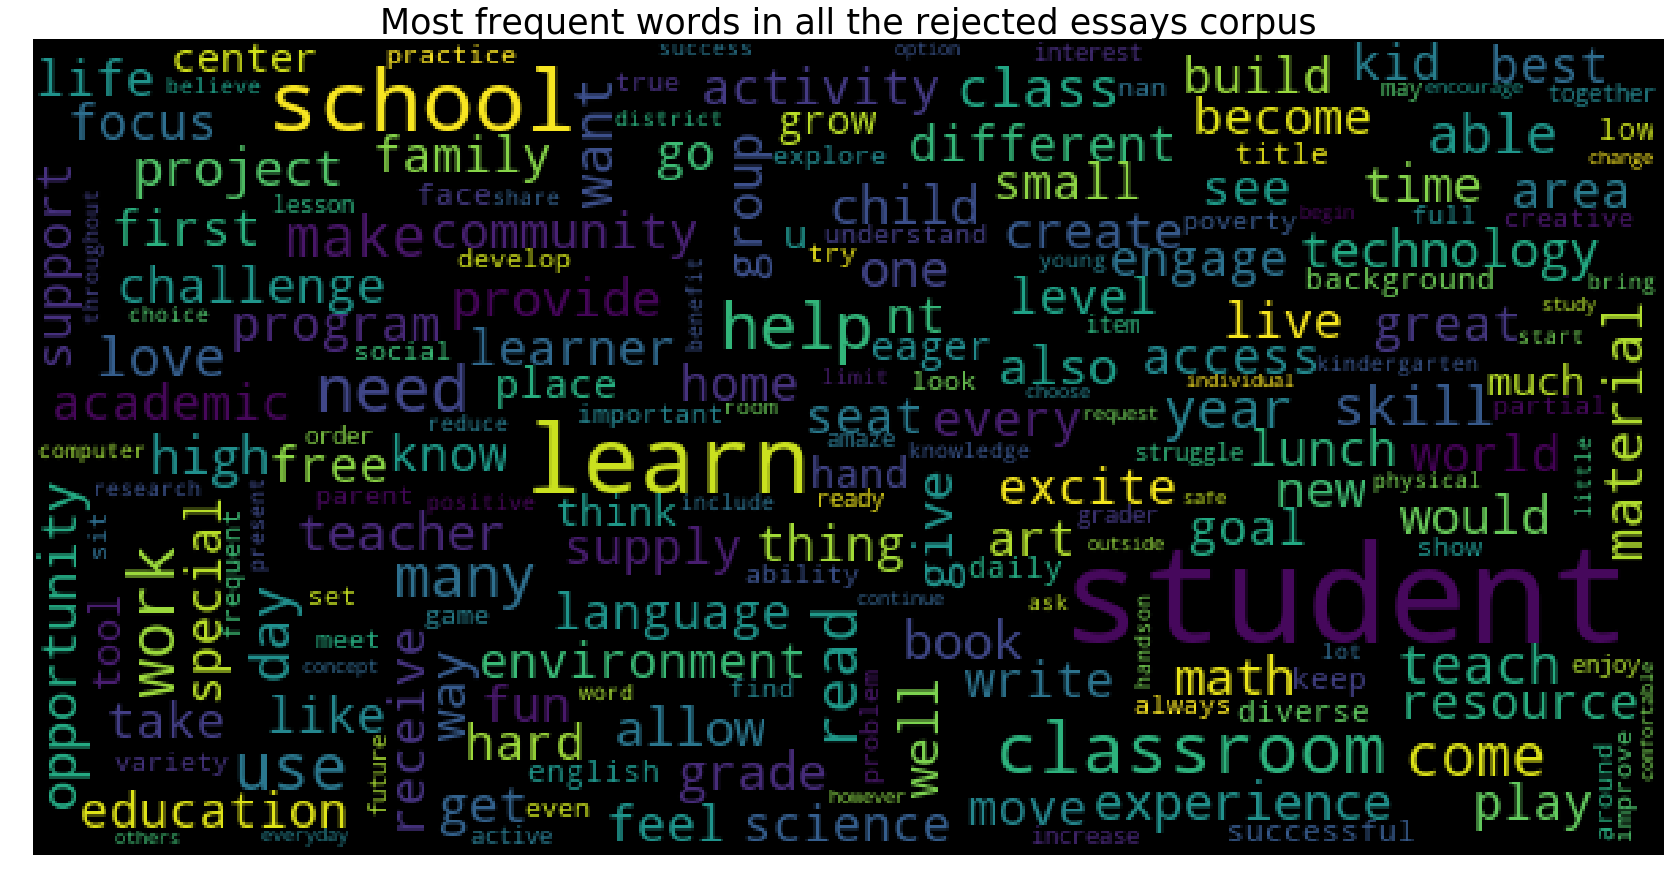

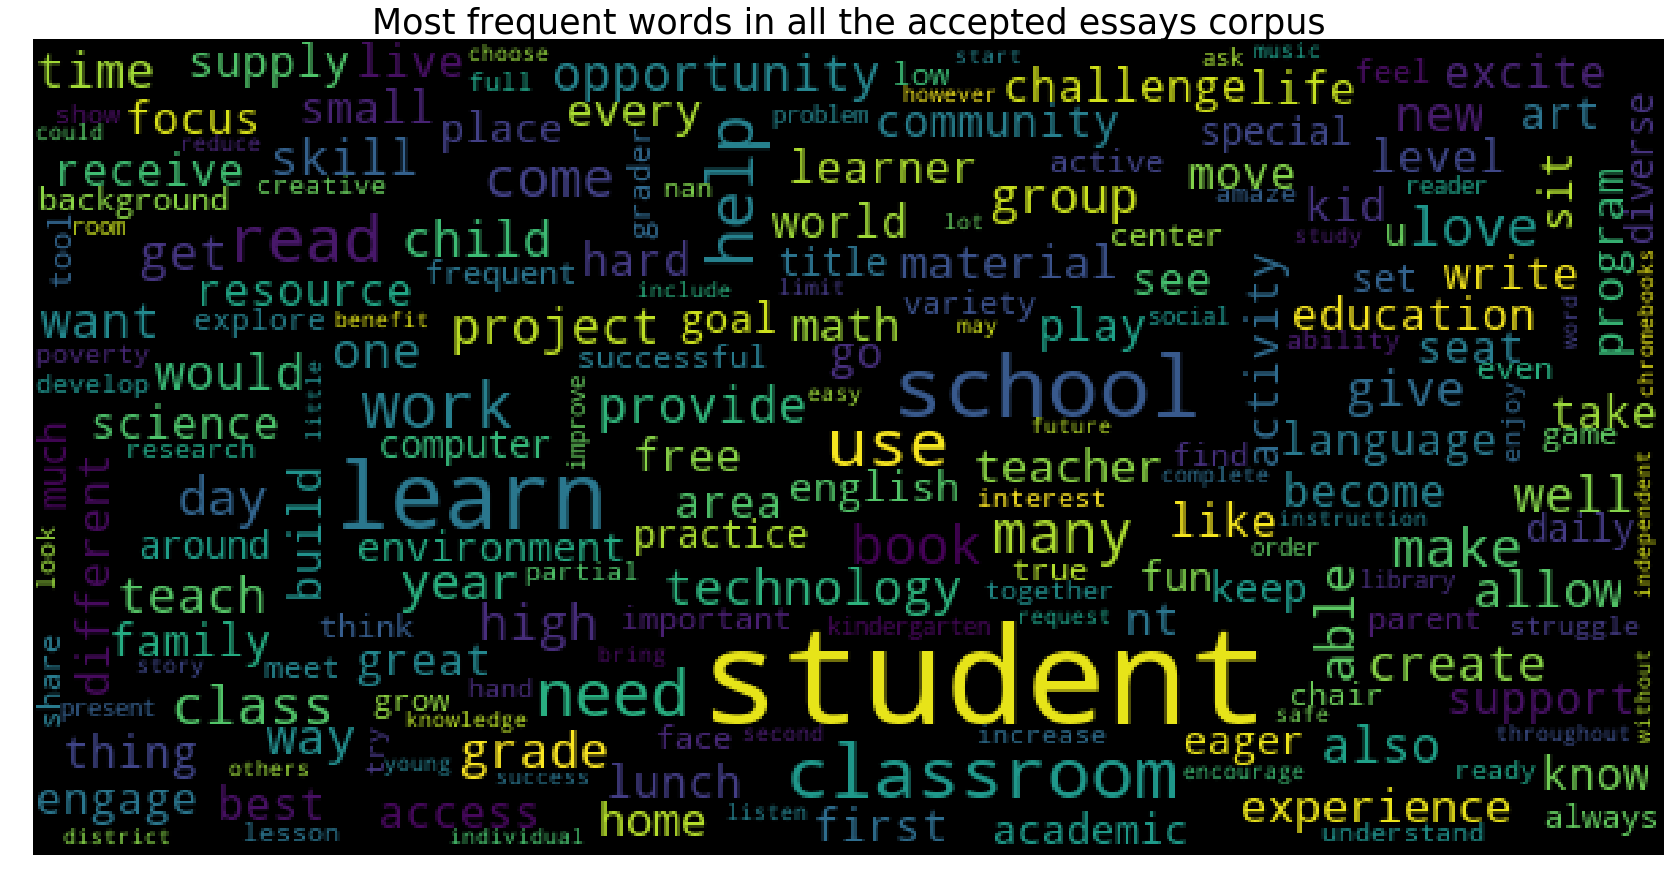

In [48]:
"""
Word cloud for just frequecneis
"""

####for rejected

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate_from_frequencies(aggTextColumns['tokenised_essay'][0])
plt.figure(figsize=(50,15))
plt.imshow(wordcloud)
plt.title("Most frequent words in all the rejected essays corpus", fontsize=35)
plt.axis("off")
plt.show() 

###for accepted
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate_from_frequencies(aggTextColumns['tokenised_essay'][1])
plt.figure(figsize=(50,15))
plt.imshow(wordcloud)
plt.title("Most frequent words in all the accepted essays corpus", fontsize=35)
plt.axis("off")
from sklearn.model_selection import train_test_split
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(sparseAll,train_df['project_is_approved'], test_size=0.20, random_state=2018)



plt.show() 

(-0.5, 599.5, 299.5, -0.5)

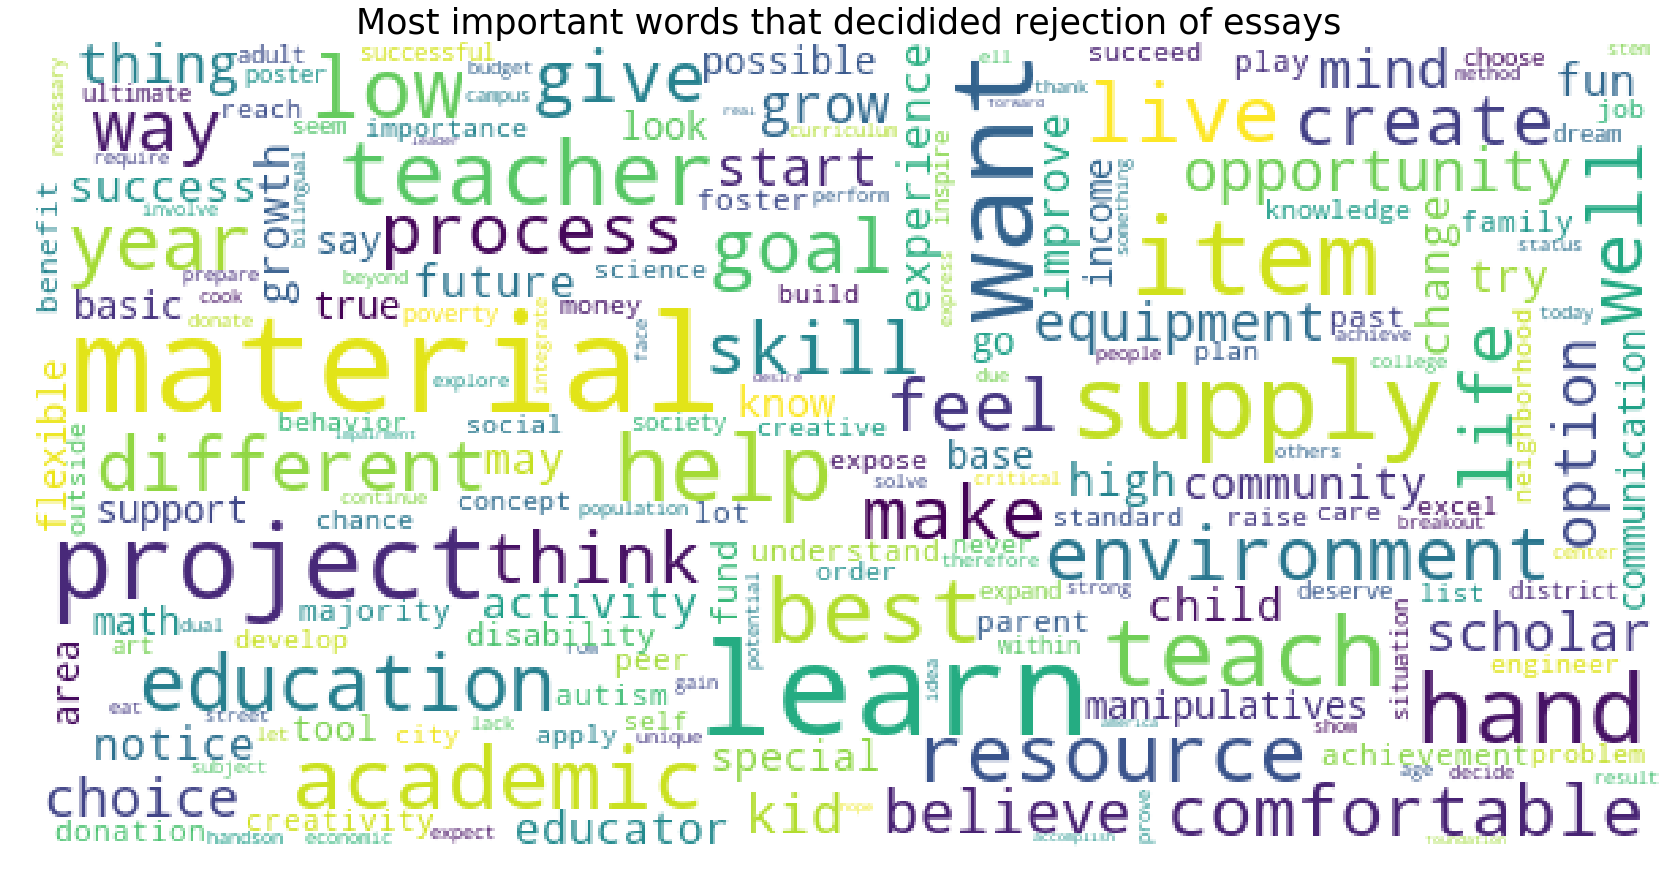

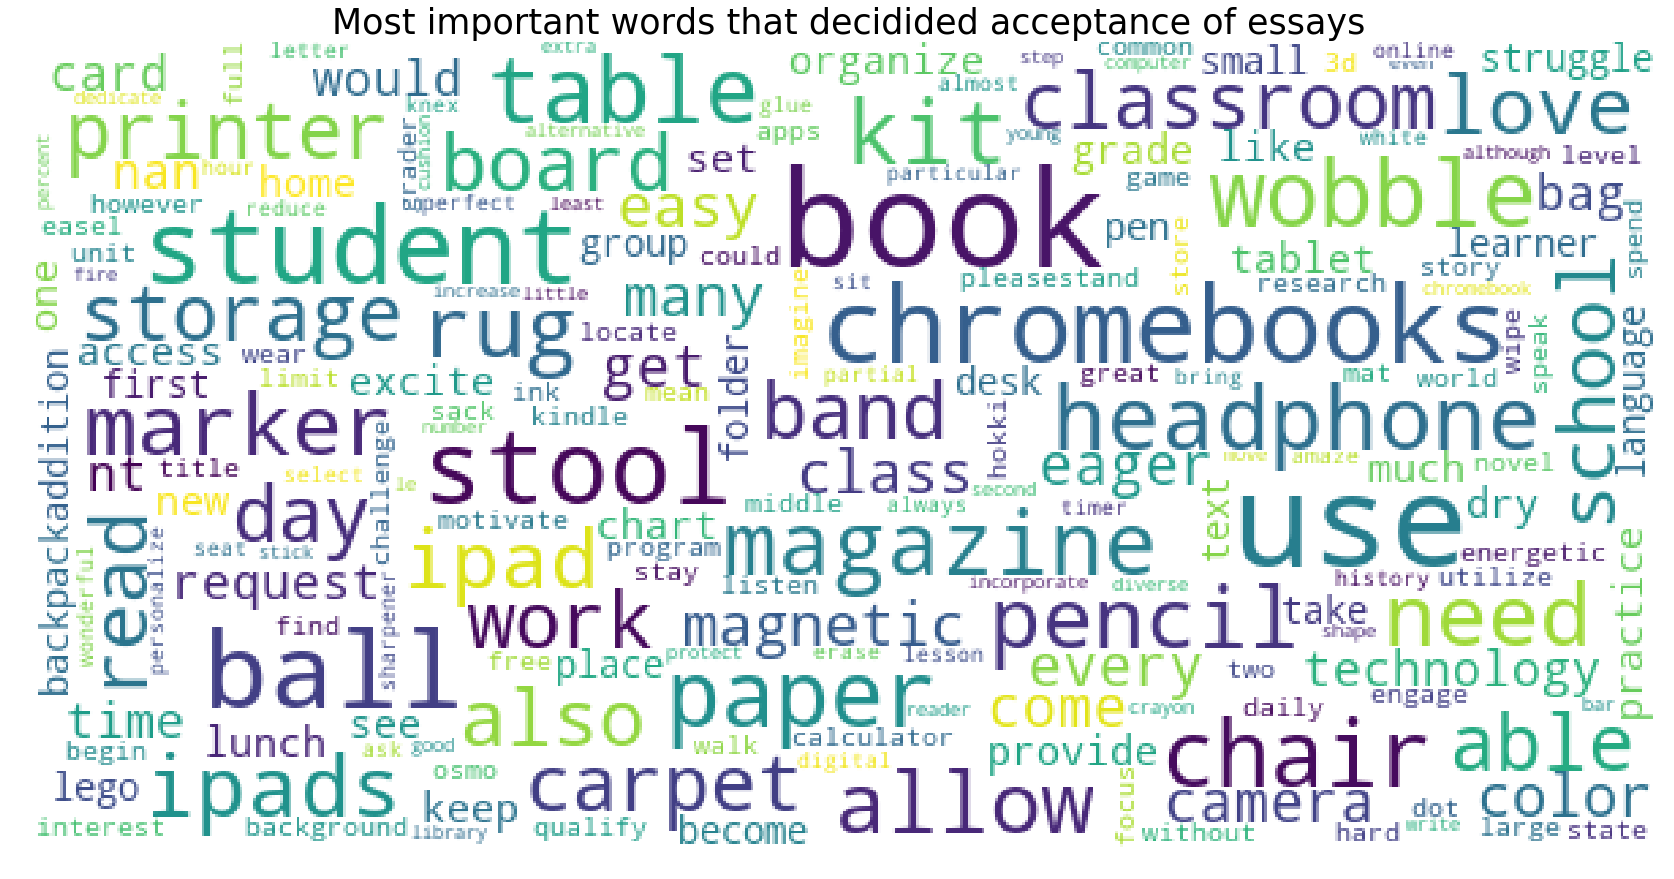

In [56]:
"""
EDA for wordcloud with important words
"""

##for rejected 
from wordcloud import WordCloud
testDict = wordScoringForEssay[wordScoringForEssay['Decision'] == -1].loc[:,['ActualWords','feature importance']].set_index('ActualWords')['feature importance'].to_dict()
plt.figure(figsize=(50,15))
wordcloud = WordCloud(max_font_size=50,background_color="white",width=600, height=300).generate_from_frequencies(testDict)
plt.title("Most important words that decidided rejection of essays", fontsize=35)                 
plt.imshow(wordcloud)
plt.axis("off")


##for accepted
from wordcloud import WordCloud
testDict = wordScoringForEssay[wordScoringForEssay['Decision'] == 1].loc[:,['ActualWords','feature importance']].set_index('ActualWords')['feature importance'].to_dict()
plt.figure(figsize=(50,15))       
wordcloud = WordCloud(max_font_size=50,background_color="white",width=600, height=300).generate_from_frequencies(testDict)
plt.title("Most important words that decidided acceptance of essays", fontsize=35) 
plt.imshow(wordcloud)
plt.axis("off")



### Essay Reviews

In [ ]:
'''
Tried using K means clustering with under sampling

'''

from imblearn.under_sampling import RandomUnderSampler
sm = RandomUnderSampler(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train_l, y_train_l)

# from sklearn.cluster import KMeans

KMeansLabeler = KMeans(n_clusters=2)
# convert lil to csr format
# note: Kmeans currently only works with CSR type sparse matrix
SparseForKmeans = sparse.hstack([x_train_res.tocsc()[:,importantWordFeatures]]) #,pd.DataFrame(y_train_res)])
KMeansLabeler.fit(SparseForKmeans) 

pd.DataFrame({'Approved': y_train_res,
            'Cluster_No': KMeansLabeler.labels_}).groupby(['Cluster_No','Approved']).size()

SparseForKmeansPrediction = sparse.hstack([X_train_l.tocsc()[:,importantWordFeatures]])#,pd.DataFrame(y_train_l)])
KMeansLabeler.predict(SparseForKmeansPrediction)

DfForNamingClusters = pd.DataFrame({'Approved': y_train_l,
                        'Cluster_No': KMeansLabeler.predict(SparseForKmeansPrediction)}).groupby(['Cluster_No','Approved']).size()

print(DfForNamingClusters)

In [65]:
subjectivity_list=train_df['sent_subjectivity'].tolist()
polarity_list=train_df['sent_polarity'].tolist()
essay_review=[]
for i,j in zip(subjectivity_list,polarity_list):
    review='Acceptable Essay'
    if i>=0.78 or i<=0.18:
        review='Poor Subjectivity'
        if(j>=0.7 or j<= 0.1):
            review='Essay Below Average'
            
    if j>=0.7 or j<=0.1:
        review='Poor Polarity'
        if(i>=0.78 or i<=0.18):
            review='Essay Below Average'
#     if i>=0.78 or i<=0.18:
#         review='Poor Subjectivity'
#     if j>=0.7 or j<=0.1:
#         review='Poor Polarity'
#     if (i>0.78 or i<0.18) and (j>0.7 or j<0.1):
#         review='Essay Below Average'
#     else:
#         review='Acceptable Essay'
    essay_review.append(review)
train_df['essay_review']=essay_review
train_df['essay_review'] = train_df['essay_review'].map({'Poor Subjectivity':0,'Poor Polarity':1,'Acceptable Essay':2,'Essay Below Average':3}) 

In [66]:
from sklearn.model_selection import train_test_split

X_trainEssayReview_l, X_testEssayReview_l,y_trainEssayReview_l , y_testEssayReview_l = train_test_split(sparseAll,
                                                              train_df['essay_review'], 
                                                              test_size=0.40, random_state=42)
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(X_trainEssayReview_l,
                                                              y_trainEssayReview_l, 
                                                              test_size=0.20, random_state=2018)


In [67]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_error',
        'max_depth': 7,
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        'num_class':4
    }  

import lightgbm as lgb
evals_result = {}  # to record eval results for plotting
model_lgb_forEssayReview = lgb.train(
        params,
        lgb.Dataset(X_train_l, y_train_l),
        num_boost_round=1000,
        valid_sets=[lgb.Dataset(X_valid_l, y_valid_l)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)
    

Training until validation scores don't improve for 100 rounds.
[25]	valid_0's multi_error: 0.0751945
[50]	valid_0's multi_error: 0.0751945
[75]	valid_0's multi_error: 0.0751945
[100]	valid_0's multi_error: 0.0751945
Early stopping, best iteration is:
[2]	valid_0's multi_error: 0.0751945


In [68]:
y_pred_essayReview = model_lgb_forEssayReview.predict(X_testEssayReview_l, num_iteration=model_lgb_forEssayReview.best_iteration)

from sklearn.metrics import roc_auc_score

roc_auc_score(pd.get_dummies(y_testEssayReview_l),y_pred_essayReview,average = 'weighted')

0.7793336503371322

In [144]:

train_df.drop(['description','teacher_id','essay','project_title','project_resource_summary'],inplace=True,axis=1)
train_df=pd.get_dummies(train_df,drop_first=True)
sparseAll_train = sparse.hstack([train_df.loc[:, ~train_df.columns.isin(['project_is_approved'])],sparseAll.tocsc()[:,importantWordFeatures]])
test_df.drop(['description','teacher_id','essay','project_title','project_resource_summary'],inplace=True,axis=1)
test_df=pd.get_dummies(test_df,drop_first=True)
sparseAll_test_df=sparse.hstack([test_df,sparseAll_test.tocsc()[:,importantWordFeatures]])


In [146]:

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(sparseAll.tocsc()[:,importantWordFeatures],
                                                              train_df['project_is_approved'], test_size=0.2, random_state=8)

Gnb = BernoulliNB()

valid_preds_naive = Gnb.fit(X_train_l, y_train_l).predict(X_valid_l)
# accuracy_score(valid_preds_naive,y_valid_l)

from sklearn.metrics import roc_auc_score


#test_preds = model_lgb.predict(test_data, num_iteration=model_lgb.best_iteration)
auc = roc_auc_score(y_valid_l, valid_preds_naive)
print('AUC:',auc)


AUC: 0.627963081513743


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(sparseAll.tocsc()[:,importantWordFeatures], train_df['project_is_approved'])
valid_preds_random_forest = clf.predict_proba(sparseAll_test.tocsc()[:,importantWordFeatures])

In [45]:
test_id=pd.read_csv("test.csv")['id']
pd.DataFrame({'id' : test_id,'project_is_approved': valid_preds_random_forest}).to_csv("RandomForestSubmission.csv", index = False)

C:\Users\rohit\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
from sklearn.model_selection import train_test_split

X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(sparseAll_train,
                                                              train_df['project_is_approved'], 
                                                              test_size=0.20, random_state=2018)
#X_train_l=sparseAll
#y_train_l=train_df['project_is_approved']

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 7,
        'num_leaves': 32,
        'learning_rate': 0.02,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
    }  

import lightgbm as lgb
evals_result = {}  # to record eval results for plotting
model_lgb = lgb.train(
        params,
        lgb.Dataset(X_train_l, y_train_l),
        num_boost_round=5000,
        valid_sets=[lgb.Dataset(X_valid_l, y_valid_l)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=25)
        
valid_preds_lgb = model_lgb.predict(sparseAll_test_df, num_iteration=model_lgb.best_iteration)

Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.679564
[50]	valid_0's auc: 0.687903
[75]	valid_0's auc: 0.698327
[100]	valid_0's auc: 0.706338
[125]	valid_0's auc: 0.712422
[150]	valid_0's auc: 0.717242
[175]	valid_0's auc: 0.720888
[200]	valid_0's auc: 0.723881
[225]	valid_0's auc: 0.726675
[250]	valid_0's auc: 0.72904
[275]	valid_0's auc: 0.731029
[300]	valid_0's auc: 0.732747
[325]	valid_0's auc: 0.734725
[350]	valid_0's auc: 0.736261
[375]	valid_0's auc: 0.73766
[400]	valid_0's auc: 0.738892
[425]	valid_0's auc: 0.74024
[450]	valid_0's auc: 0.741238
[475]	valid_0's auc: 0.742484
[500]	valid_0's auc: 0.743524
[525]	valid_0's auc: 0.744422
[550]	valid_0's auc: 0.74545
[575]	valid_0's auc: 0.74619
[600]	valid_0's auc: 0.746634
[625]	valid_0's auc: 0.747147
[650]	valid_0's auc: 0.7478
[675]	valid_0's auc: 0.748432
[700]	valid_0's auc: 0.749157
[725]	valid_0's auc: 0.749929
[750]	valid_0's auc: 0.750364
[775]	valid_0's auc: 0.750853
[800]	valid_0's a

C:\Users\harsh\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [151]:
test_id=pd.read_csv("test.csv")['id']
pd.DataFrame({'id' : test_id,'project_is_approved': valid_preds_lgb}).to_csv("LightGBMSubmission.csv", index = False)

C:\Users\harsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
